## Notebook Visualisation of Rotational Positional Encoding

In this notebook example, I want to visualise Llama's implementation of Rotational Positional Encoding. To make this more relatable, I have implemented it in the same attention class of the GPT2 decoder architecture that was previously missing the functions catering for the RoPE.

In [275]:
import torch
import torch.nn as nn
from torch.functional import F

class Head_with_rope(nn.Module):
    def __init__(self, head_size, n_embed, block_size, is_causal):
        super().__init__()
        self.head_size = head_size
        self.q = nn.Linear(n_embed, head_size)
        self.k = nn.Linear(n_embed, head_size)
        self.v = nn.Linear(n_embed, head_size)
        if is_causal:
            self.register_buffer('triu', torch.triu(torch.ones(block_size, block_size), diagonal=1)) # If causal, then the upper half of the matrix is masked. This would be causal self-attention
        else:
            self.register_buffer('triu', torch.triu(torch.zeros(block_size, block_size), diagonal=1)) # if non-causal, then the whole matrix is not masked. This would be bidirectional self-attention
        self.dropout = nn.Dropout()

    def forward(self, x, mask=None):
        B,T,C = x.shape
        Q = self.q(x)
        K = self.k(x)
        V = self.v(x)

        ## If there's a padding mask, we want to adjust the attention mask.
        if mask is not None: # if there's a padding mask to factor in input tokens that have the pad_token_id
            causal_mask = self.triu[:T,:T].unsqueeze(0) == 1 # upper half of the matrix is True
            ## mask is True where the padding token is
            mask = (mask == 0) ## ! - Need to replace 0 with self.tokenizer.pad_token_id
            attn_mask = causal_mask + mask.unsqueeze(-1) # True + False = True
        else: 
            attn_mask = self.triu[:T,:T].unsqueeze(0) == 1 # upper half of the matrix is True

        ## Scaled dot product attention
        attention = Q @ K.transpose(-2,-1) * (C ** -0.5) # B,T,T
        attention = attention.masked_fill(attn_mask, float('-inf')) # B,T,T # replaces the True values with -inf
        attention = F.softmax(attention, dim=-1) # B,T,T
        attention = self.dropout(attention)
        out = attention @ V # B,T,H
        return out

    def apply_and_get_rope(self, x, mask=None):
        B,T,C = x.shape
        Q = self.q(x) # B,T,H
        K = self.k(x) # B,T,H
        V = self.v(x) # B,T,H

        ## prep the freqs_cis
        dim = Q.shape[-1]
        end = Q.shape[1]
        freqs_cis = precompute_freqs_cis(dim, end)

        ## get the rope embeddings of Q and K
        Q_rope, K_rope = apply_rotary_emb(Q, K, freqs_cis)

        return Q, K, Q_rope, K_rope

def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device)
    freqs = torch.outer(t, freqs).float()
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    ndim = x.ndim
    assert 0 <= 1 < ndim
    assert freqs_cis.shape == (x.shape[1], x.shape[-1])
    shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
    return freqs_cis.view(*shape)

def apply_rotary_emb(xq: torch.Tensor, xk: torch.Tensor, freqs_cis: torch.Tensor):
    # Reshape to complex numbers
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    
    # Broadcast frequencies
    freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    
    # Apply the rotary embeddings
    xq_out = torch.view_as_real(xq_ * freqs_cis).reshape(*xq.shape)
    xk_out = torch.view_as_real(xk_ * freqs_cis).reshape(*xk.shape)
    
    return xq_out.type_as(xq), xk_out.type_as(xk)

## hiding this because this is exactly the same as Llama's implementation,
## however, we have opted not to flatten because we want to keep the 3D structure
## of the tensors that our GPT2 model processes. 
# def apply_rotary_emb(xq: torch.Tensor, xk: torch.Tensor, freqs_cis: torch.Tensor):
#     xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
#     xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
#     freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
#     xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
#     xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
#     return xq_out.type_as(xq), xk_out.type_as(xk)

In [280]:
### Parameters
head_size = 2
# - The head_size needs to be an even number for the rotary embeddings to work
# - using 2 so that it's easier for demonstration purposes on a 2D plot
n_embed = 4
block_size = 3
is_causal = True

### Create the head
head = Head_with_rope(head_size, n_embed, block_size, is_causal)

### create some dummy data
# Create a simple token_embedding_table that has vocab_size and n_embed
vocab_size = 5
token_embedding_table = torch.randn(vocab_size, n_embed)
# Create a dummy input tensor. For each batch, we'll use the same input tensor id.
# This is so that we can see how the input tensor, upon being multiplied with 
# the same Q and K weights, will have different outputs as it goes down the positional
# indexes. Its difference will be the attribution of rotation embeddings being put
# to work. 
x_inputs = torch.tensor([[1,1,1,1],[2,2,2,2]])
x = token_embedding_table[x_inputs]

### Get the rope embeddings
Q, K, Q_rope, K_rope = head.apply_and_get_rope(x)

print('Shape of Attention, weight Q:', Q.shape)
print('Attention, weight Q:\n', Q)
print('----------------------------------------------------')
print('Shape of Q_rope:', Q_rope.shape)
print('Q_rope:\n', Q_rope)

Shape of Attention, weight Q: torch.Size([2, 4, 2])
Attention, weight Q:
 tensor([[[-0.3186,  0.5949],
         [-0.3186,  0.5949],
         [-0.3186,  0.5949],
         [-0.3186,  0.5949]],

        [[-0.9609,  0.3559],
         [-0.9609,  0.3559],
         [-0.9609,  0.3559],
         [-0.9609,  0.3559]]], grad_fn=<ViewBackward0>)
----------------------------------------------------
Shape of Q_rope: torch.Size([2, 4, 2])
Q_rope:
 tensor([[[-0.3186,  0.5949],
         [-0.6728,  0.0534],
         [-0.4084, -0.5373],
         [ 0.2314, -0.6339]],

        [[-0.9609,  0.3559],
         [-0.8187, -0.6163],
         [ 0.0763, -1.0219],
         [ 0.9011, -0.4880]]], grad_fn=<ViewBackward0>)


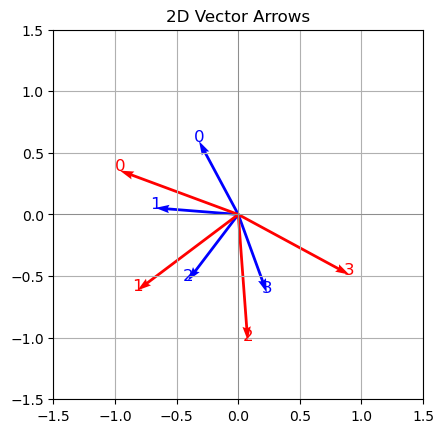

In [282]:
import torch
import matplotlib.pyplot as plt

# Given tensor
tensor = Q_rope

# Extract the components for the quiver plot
x = tensor[:,:,0].detach().numpy()  # x components
y = tensor[:,:,1].detach().numpy()  # y components

# Create a figure and axis
fig, ax = plt.subplots()

# Define the starting points of the vectors
num_vectors = x.shape[0] * x.shape[1]
origin_x = [0] * num_vectors
origin_y = [0] * num_vectors

# Flatten the arrays for quiver plotting
x_flat = x.flatten()
y_flat = y.flatten()

# Create a colormap for dim 0
colors = ['b', 'r']
color_labels = [colors[i] for i in range(x.shape[0]) for _ in range(x.shape[1])]

# Create the quiver plot
ax.quiver(origin_x, origin_y, x_flat, y_flat, angles='xy', scale_units='xy', scale=1, color=color_labels)

# Add labels to each vector
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        label = f'{j}'
        ax.text(x[i, j], y[i, j], label, color=colors[i], fontsize=12, ha='center')

# Set the limits and labels for better visualization
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.axhline(0, color='gray', linewidth=0.5)
ax.axvline(0, color='gray', linewidth=0.5)
ax.grid(True)
ax.set_aspect('equal', 'box')
ax.set_title("2D Vector Arrows")

plt.show()


Focusing on just the Query vector, we can tell that the rotational embedding works. This is observed in 2 ways. 

The first is looking at the tensor, results for Q. Because of the same input embeddings pulled from the vocab_embedding_table, we have evidence that without the rotational embedding, it will be these common set of values across the positional indices. However, upon applying rope to get Q_rope, we can see that apart from index = 0, the other indices values are differentiated from the original Q. Only index = 0 are the same across Q and Q_rope. This is suppose to be the case because according to the RoPE implementation, index 0 has no rotation applied to it. 

The second piece of evidence is looking at the 2D vector diagram plot of each batch. Observe how the indices vector are each uniformly rotated off of the original vector (index = 0). 